In [1]:
import os
import torch
import numpy as np
import cv2
import traceback
from tqdm import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
from scipy.stats import norm
import scienceplots
from matplotlib.patches import Patch

import pySPM

Loaded image: dummy_SLSQA_003 with shape (256, 512)
Loaded image: dummy_SLSQC_006 with shape (256, 512)
Loaded image: dummy_SLSQH_012 with shape (256, 512)
Loaded image: real_SLSQA_012 with shape (256, 512)
Loaded image: real_SLSQC_141 with shape (256, 512)
Loaded image: real_SLSQH_008 with shape (256, 512)
Successfully loaded 6 images
dummy_SLSQA_003


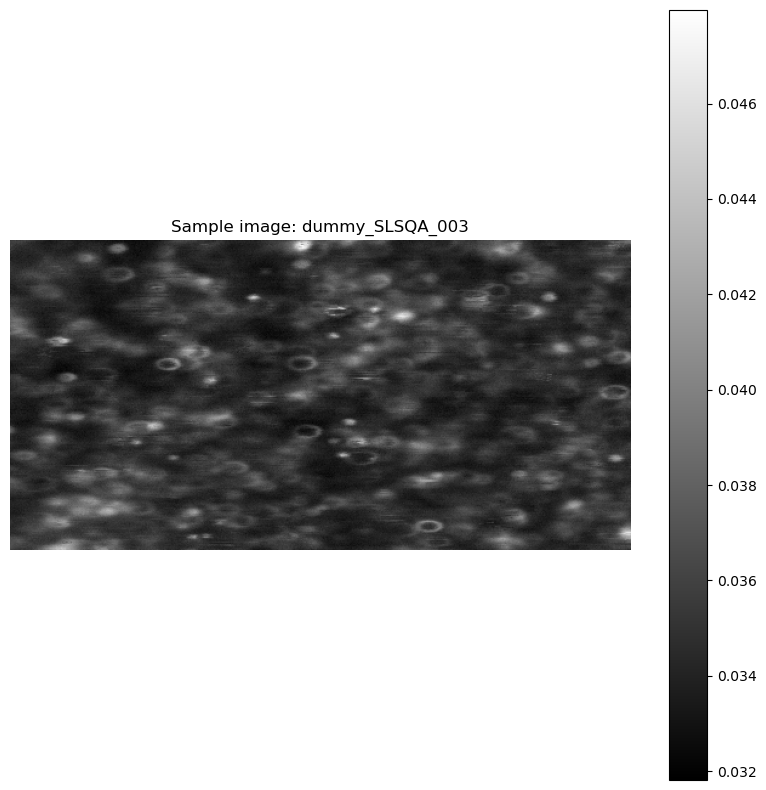

In [4]:
# Define directory path where images are stored
# NOTE: THIS NEEDS TO BE CHANGED TO WHEREVER THE IMAGES ARE STORED FOR YOU
image_dir = 'SLSQ_traps' 

# Dictionary to store the images
trap_images = {}

# Check if the directory exists
if os.path.exists(image_dir):
    # List all files in the directory
    files = os.listdir(image_dir)
    
    # Filter for .sxm files (assuming they have common image extensions)
    ext = '.sxm'
    image_files = [f for f in files if f.lower().endswith(ext)]
    
    # Load each image into the dictionary
    for img_file in image_files:
        # Read the image
        img_path = os.path.join(image_dir, img_file)
        try:
            # Open image
            img = pySPM.SXM(img_path).get_channel('Excitation').pixels
            # Use filename without extension as the key
            key = os.path.splitext(img_file)[0]
            trap_images[key] = img
            print(f"Loaded image: {key} with shape {img.shape}")
        except Exception as e:
            print(f"Error loading {img_file}: {e}")
    
    print(f"Successfully loaded {len(trap_images)} images")
else:
    print(f"Directory {image_dir} does not exist")

# Display a sample image if any were loaded
if trap_images:
    # Pick first image to display
    sample_key = next(iter(trap_images))
    print(sample_key)
    plt.figure(figsize=(10, 10))
    plt.imshow(trap_images[sample_key], cmap='gray')
    plt.title(f"Sample image: {sample_key}")
    plt.colorbar()
    plt.axis('off')
    plt.show()

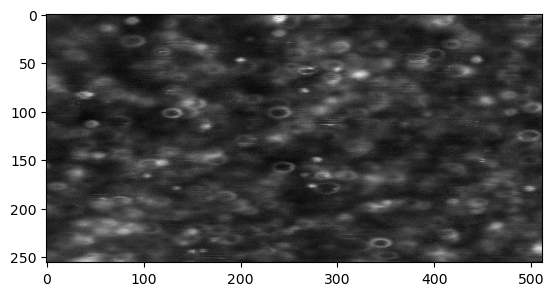

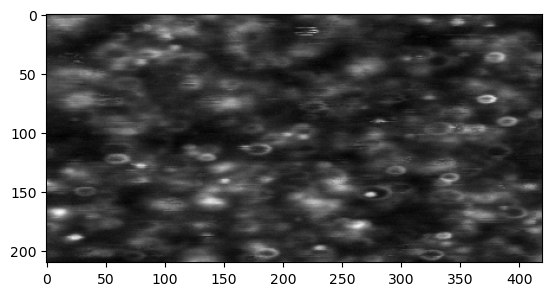

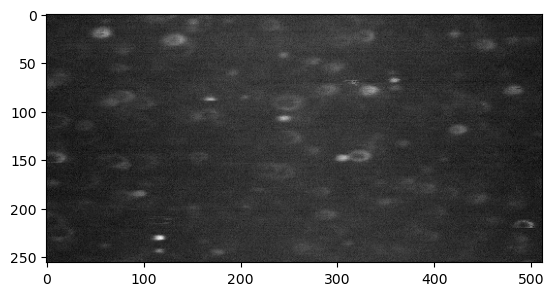

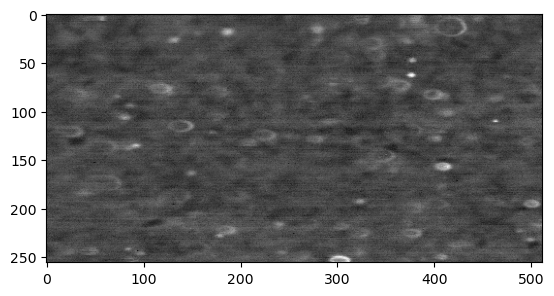

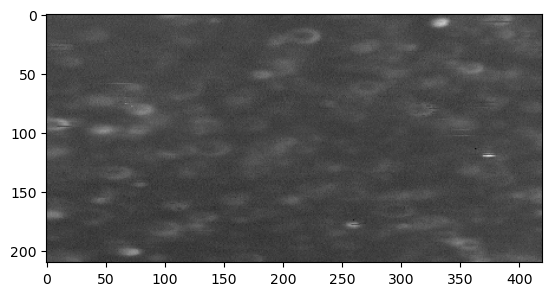

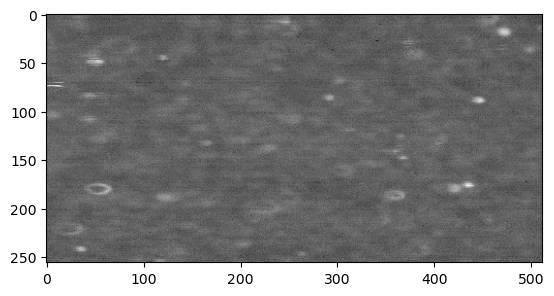

In [5]:
i = 1
for key, value in trap_images.items():
    if i==2:
        yres = 210
        xres = int(512*yres/256)
        value = value[:yres,:xres]
    if i == 5:
        yres = 210
        xres = int(512*yres/256)
        value = value[:yres,:xres]
    
    plt.imshow(value, cmap='gray')
    plt.show()

    i+=1

In [3]:
# definition of some functions needed for the YOLOv8 model loading and prediction

def load_yolov8_model(model_path, conf_threshold=0.25, device=None):
    """
    Load a trained YOLOv8 model for inference.
    
    Args:
        model_path (str): Path to the trained model (.pt file)
        conf_threshold (float): Confidence threshold for detections (0-1)
        device (str, optional): Device to run the model on ('cpu', 'cuda:0', etc.).
                               If None, will use cuda if available
    
    Returns:
        model: Loaded YOLO model ready for inference
    """
    try:
        print(f"Loading YOLOv8 model from {model_path}")
        
        # Check if file exists
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model file not found: {model_path}")
            
        # Set device if not specified
        if device is None:
            device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        
        # Load the model
        model = YOLO(model_path, verbose=False)
        
        # Move model to specified device
        model.to(device)
        
        print(f"Model loaded successfully on {device}")
        
        return model
        
    except Exception as e:
        print(f"Error loading YOLOv8 model: {e}")
        print(traceback.format_exc())
        return None
    
def predict_image(model, output_path, image_path=None, image_array=None, conf_threshold=0.25, save_output=False, iterations=100):
    """
    Run prediction on an image file or numpy array.
    Resizes input to 640x640 for optimal YOLOv8 performance.
    
    Args:
        model: Loaded YOLOv8 model
        image_path (str, optional): Path to image file
        image_array (numpy.ndarray, optional): Image as numpy array
        conf_threshold (float): Confidence threshold
        save_output (bool): Whether to save output image with detections
        iterations (int): Number of iterations for Monte Carlo Dropout
        
    Returns:
        detections: Dictionary containing detection results
    """
    if model is None:
        print("Error: No model provided")
        return None
        
    try:
        # Process input based on type
        if image_path is not None:
            if not os.path.exists(image_path):
                print(image_path)
                raise FileNotFoundError(f"Image file not found: {image_path}")
            
            # Load the image
            img = cv2.imread(image_path)
            print(img.shape)
            img = img[:213,:(213*2)]
            print(img.shape)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Resize to 640x640
            img_resized = cv2.resize(img, (640, 640))


            # Run prediction directly on the resized image
            model.eval()
            results = model(img_resized, conf=conf_threshold)

            mean_num_donuts, std_dev = count_with_mc_dropout(model, img_resized, iterations=iterations, conf_threshold=conf_threshold)
            print(f"Mean number of donuts: {mean_num_donuts:.2f} +/- {std_dev:.2f}")
            
        elif image_array is not None:
            # Get original dimensions
            
            # Convert array to suitable format
            img = image_array.copy()
            
            # Convert grayscale to RGB if needed
            if len(img.shape) == 2:
                img = np.stack([img] * 3, axis=2)
            elif len(img.shape) == 3 and img.shape[2] == 1:
                img = np.repeat(img, 3, axis=2)
            
            # Scale to 0-255 range if needed
            if img.dtype == np.float32 or img.dtype == np.float64:
                if img.max() <= 1.0:
                    img = (img * 255).astype(np.uint8)
                else:
                    img = img.astype(np.uint8)
            print(img.shape)
            img = img[:213,:(213*2)]
            print(img.shape)

            # Resize to 640x640
            img_resized = cv2.resize(img, (640, 640))
            
            # Run prediction directly on the resized array
            results = model(img_resized, conf=conf_threshold)
            
            mean_num_donuts, std_dev = count_with_mc_dropout(model, img_resized, iterations=iterations, conf_threshold=conf_threshold)
            print(f"Mean number of donuts: {mean_num_donuts:.2f} +/- {std_dev:.2f}")
            
        else:
            raise ValueError("Either image_path or image_array must be provided")
        
        # Extract results
        if len(results) > 0:
            # Get boxes, confidence scores and class ids
            boxes = results[0].boxes.xyxy.cpu().numpy()  # x1, y1, x2, y2 format
            confidence = results[0].boxes.conf.cpu().numpy()
            class_ids = results[0].boxes.cls.cpu().numpy().astype(int)
            
            # Print number of donuts detected
            num_donuts = len(boxes)
            print(f"Number of donuts detected: {num_donuts}")
            
            
            # Save output image if requested
            if save_output:
                # Create a visualization using original dimensions
                if image_path is not None:
                    output_img = img_resized.copy()
                    output_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
                else:
                    output_img = img.copy()  # Use the processed image from earlier
                
                # Draw boxes without confidence labels
                for box in boxes:
                    x1, y1, x2, y2 = box.astype(int)
                    cv2.rectangle(output_img, (x1, y1), (x2, y2), (0, 255, 0), 1)
                
                # Save clean visualization
                plt.figure(figsize=(10, 10))
                plt.imshow(output_img)
                plt.title(f"Detected {int(num_donuts)} rings")
                plt.axis('off')
                plt.tight_layout()
                plt.savefig(output_path, dpi=300, bbox_inches='tight')
                plt.close()
                print(f"Detection image saved to {output_path}")
                
            # Return structured results
            return {
                'boxes': boxes,
                'confidence': confidence,
                'class_ids': class_ids,
                'num_detections': num_donuts,
                'raw_results': results,
                'mean_num_donuts': mean_num_donuts,
                'std_dev': std_dev,
                'img': output_img,
            }
        else:
            print("Number of donuts detected: 0")
            return {
                'boxes': np.array([]),
                'confidence': np.array([]),
                'class_ids': np.array([]),
                'num_detections': 0,
                'raw_results': results,
                'mean_num_donuts': 0,
                'std_dev': 0,
                'img': None,
            }
            
    except Exception as e:
        print(f"Error during prediction: {e}")
        print(traceback.format_exc())
        return None

def count_with_mc_dropout(model, image, class_id=0, iterations=10, conf_threshold=0.25):
    """
    Use Monte Carlo Dropout to estimate count uncertainty
    """
    # Enable dropout during inference
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()
    
    counts = []
    for _ in range(iterations):
        results = model.predict(image, conf=conf_threshold)
        count = sum(len([b for b in r.boxes if b.cls.item() == class_id]) for r in results)
        counts.append(count)
    
    mean_count = np.mean(counts)
    std_dev = np.std(counts)
    
    # Return mean and standard error
    return mean_count, std_dev


    """
    Count donuts in all images in a directory.
    
    Args:
        model: Loaded YOLOv8 model
        directory_path (str): Path to directory containing images
        conf_threshold (float): Confidence threshold
        
    Returns:
        results: Dictionary containing counts for each image
    """
    if not os.path.isdir(directory_path):
        print(f"Directory not found: {directory_path}")
        return None
        
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    image_files = [f for f in os.listdir(directory_path) 
                  if any(f.lower().endswith(ext) for ext in image_extensions)]
    
    if not image_files:
        print(f"No image files found in {directory_path}")
        return None
    
    results = {}
    total_donuts = 0
    
    print(f"Processing {len(image_files)} images...")
    
    for image_file in tqdm(image_files):
        image_path = os.path.join(directory_path, image_file)
        
        # Run prediction
        detections = predict_image(model, image_path=image_path, conf_threshold=conf_threshold)
        
        if detections is not None:
            num_donuts = detections['num_detections']
            results[image_file] = num_donuts
            total_donuts += num_donuts
    
    print(f"Total donuts detected: {total_donuts} in {len(image_files)} images")
    print(f"Average donuts per image: {total_donuts / len(image_files):.2f}")
    
    return results

In [8]:
# load model

model = load_yolov8_model(r'C:\Users\nkolev\OneDrive - University College London\Documents\GitHub\SLSQ\yolov8_trap_count\yolov8_model_m_04_04_2025\yolov8_m_donuts\weights\best.pt')

Loading YOLOv8 model from C:\Users\nkolev\OneDrive - University College London\Documents\GitHub\SLSQ\yolov8_trap_count\yolov8_model_m_04_04_2025\yolov8_m_donuts\weights\best.pt
Model loaded successfully on cpu


In [9]:
# Make predictions on the experimental images



#  Define directory path where images are stored
image_dir = 'SLSQ_traps/' 

# Dictionary to store the images
trap_paths = []
images = []

# Check if the directory exists
if os.path.exists(image_dir):
    # add paths to .pngs in this dir only (not its roots)
    for file in os.listdir(image_dir):
        if file.endswith(".png"):
            trap_paths.append(os.path.join(image_dir, file))
            images.append(file)

print(trap_paths)


predictions = {}
for image_name, path in zip(images,trap_paths):
    predictions[image_name] = predict_image(model,output_path=f'C:\\Users\\nkolev\\OneDrive - University College London\\Documents\\GitHub\\SLSQ\\SLSQ_traps\\preds\\prediction{image_name}', 
                                     image_path=path, conf_threshold=0.35, save_output=True, iterations = 20)
    

# print all means and stds
for image_name, pred in predictions.items():
    print(f"Image: {image_name} - Mean donuts: {pred['mean_num_donuts']:.2f}, Std: {pred['std_dev']:.2f}")
    

['SLSQ_traps/dummy_SLSQA_003.png', 'SLSQ_traps/dummy_SLSQC_006.png', 'SLSQ_traps/dummy_SLSQH_012.png', 'SLSQ_traps/real_SLSQA_012.png', 'SLSQ_traps/real_SLSQC_141.png', 'SLSQ_traps/real_SLSQH_008.png']
(256, 512, 3)
(213, 426, 3)

0: 640x640 187 donuts, 660.8ms
Speed: 6.7ms preprocess, 660.8ms inference, 17.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 177 donuts, 581.4ms
Speed: 4.7ms preprocess, 581.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 177 donuts, 615.9ms
Speed: 4.6ms preprocess, 615.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 181 donuts, 657.2ms
Speed: 3.4ms preprocess, 657.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 179 donuts, 596.3ms
Speed: 4.0ms preprocess, 596.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 174 donuts, 572.4ms
Speed: 2.9ms preprocess, 572.4ms inference, 2.3ms postprocess per image at shape (1, 3,

KeyboardInterrupt: 

In [10]:
detections = {'1': ['Raw','No Anneal', 188.0, 7.6 ],
              '2': ['Raw','N2', 178.5, 10.0],
              '3': ['Raw', 'N2+H2', 12.8, 1.25],
              '4': ['UHV', 'No Anneal', 30.0, 2.8],
              '5': ['UHV', 'N2', 20.2, 1.4],
              '6': ['UHV', 'N2+H2', 7.2, 1.1]}

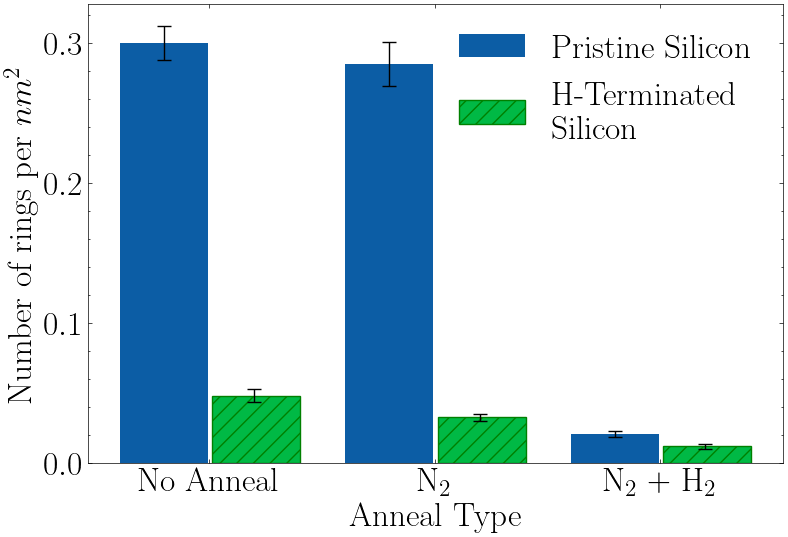

In [11]:
plt.style.use('science')

total_area = 625^2  # nm^2

raw_density = np.array([188.0, 178.5, 12.8]) / total_area
h_density = np.array([30.0, 20.2, 7.2]) / total_area

raw_std = np.array([7.6, 10.0, 1.25]) / total_area
h_std = np.array([2.8, 1.4, 1.1]) / total_area

x_labels = ['No Anneal', r'N$_2$', r'N$_2$ + H$_2$']
row_labels = ['Pristine Silicon', 'H-Capped Silicon']

x_pos = np.arange(3)
width = 0.4


plt.rcParams.update({'font.size': 24})

plt.figure(figsize=(8.5, 6))
plt.bar(x_pos - width/2,raw_density, width = width - 0.01, label = 'Pristine Silicon')
plt.errorbar(x_pos - width/2, raw_density, yerr=raw_std, fmt=' ', color='black', capsize=5)
plt.bar(x_pos + width/2 +0.01, h_density, width = width - 0.01, label = 'H-Terminated \n Silicon', hatch='//', edgecolor='green')
plt.errorbar(x_pos + width/2, h_density, yerr=h_std, fmt=' ', color='black', capsize=5)

plt.xticks(x_pos, x_labels)

# Remove any unwanted intermediate ticks
plt.gca().xaxis.set_major_locator(plt.FixedLocator(x_pos))  # Force tick locations
plt.gca().xaxis.set_minor_locator(plt.NullLocator())  # Disable minor ticks

plt.xlabel('Anneal Type')
plt.ylabel(r'Number of rings per $nm^2$')
plt.legend()
#plt.ylim(0, 160)

plt.legend()
plt.tight_layout()
plt.savefig('C:\\Users\\nkolev\\OneDrive - University College London\\Documents\\GitHub\\SLSQ\\SLSQ_traps\\bar_chart_num_rings.eps', pad_inches=0.2)
plt.show()

In [20]:
images = []
for key, value in predictions.items():
    images.append(value['img'])

images = np.array(images)
print(images.shape)

    

(6, 640, 640, 3)


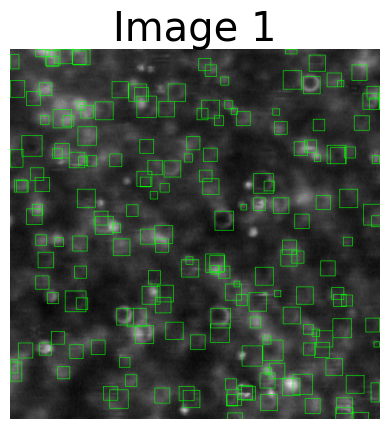

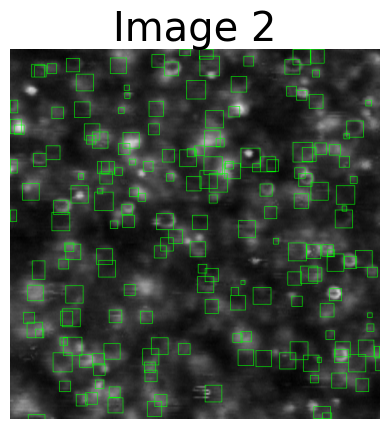

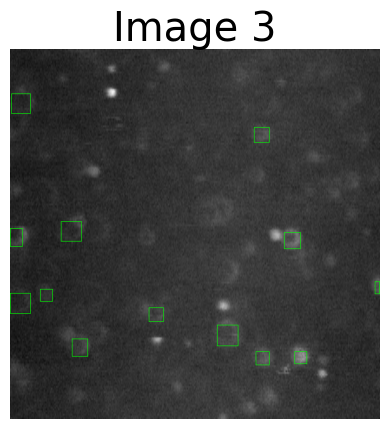

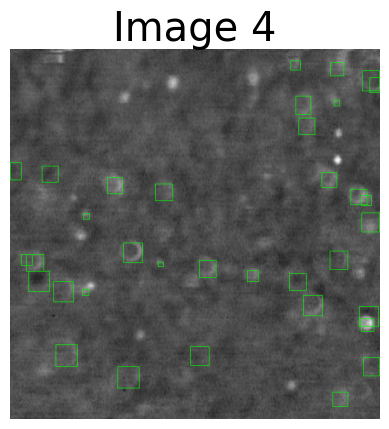

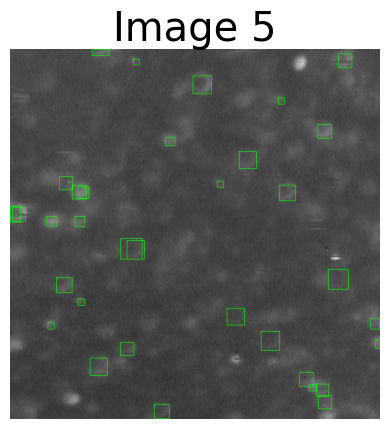

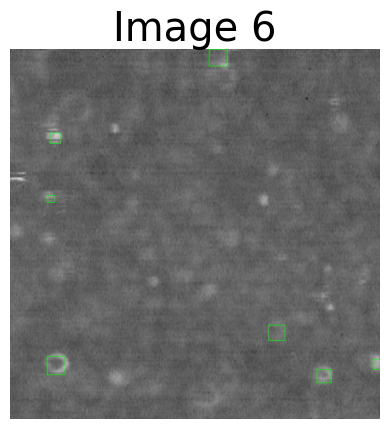

In [21]:
for i in range(images.shape[0]):
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Image {i+1}")
    plt.axis('off')
    plt.show()

In [6]:

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import matplotlib.patheffects as path_effects

(640, 640, 3)
(640, 640, 3)
(640, 640, 3)


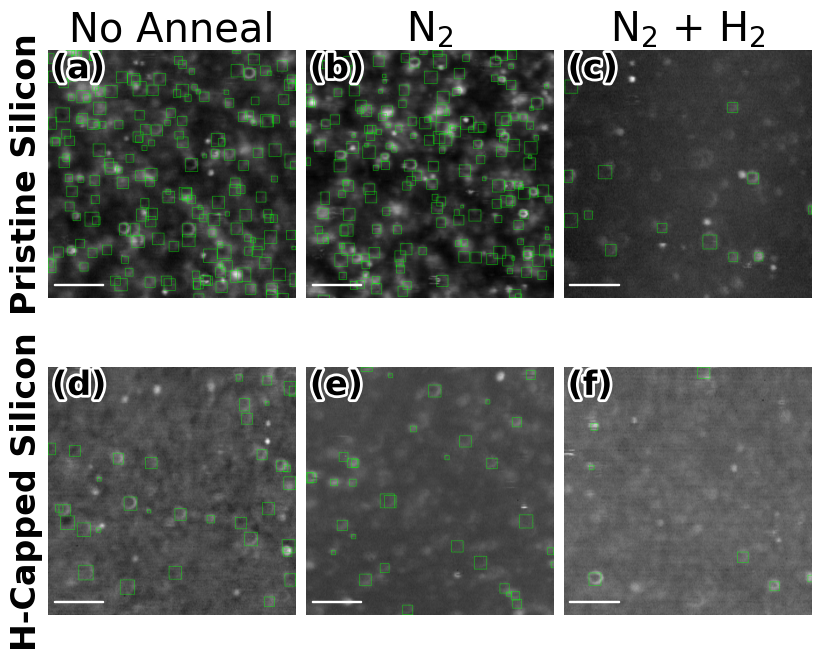

In [22]:
# Visualize the Images

# Input your array of 6 images here instead of normalized_imgs
imgs_row1 = images[:3]
imgs_row2 = images[3:]

titles = ['No Anneal', r'N$_2$', r'N$_2$ + H$_2$']
row_labels = ['Pristine Silicon', 'H-Capped Silicon']
ref = np.array([['(a)', '(b)', '(c)'],['(d)', '(e)', '(f)']])

plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(8, 8))

for col in range(3):
    # First row
    im = ax[0, col].imshow(imgs_row1[col]) # adjust cmap to gray scale if you like
    print(imgs_row1[col].shape)
    ax[0, col].set_title(titles[col])
    ax[0, col].axis('off')
   # ax[0, col].set_aspect(512/211) # adjust aspect ratio to yours, I think it should just be 2 in your case

    
    scalebar = AnchoredSizeBar(ax[0, col].transData, 
                               128,  # Length of the scale bar in data units
                               '',  # Scale bar label
                               loc='lower left',  # Location of the scale bar
                               pad=2, 
                               color='white', 
                               frameon=False,
                               size_vertical=2, 
                               fontproperties=fm.FontProperties(size=2))
    ax[0, col].add_artist(scalebar)

    # add reference labels to the subfigures
    text = ax[0, col].text(10, 5, ref[0, col], fontsize=24,
            fontweight='heavy', color='black', va='top', ha='left')

    text.set_path_effects([path_effects.Stroke(linewidth=4, foreground='white'), 
                       path_effects.Normal()])

    # Second row
    im = ax[1, col].imshow(imgs_row2[col])
    
    ax[1, col].axis('off')
  
    scalebar = AnchoredSizeBar(ax[1, col].transData, 
                               128,  # Length of the scale bar in data units
                               '',  # Scale bar label
                               loc='lower left',  # Location of the scale bar
                               pad=2, 
                               color='white', 
                               frameon=False,
                               size_vertical=2, 
                               fontproperties=fm.FontProperties(size=2))
    ax[1, col].add_artist(scalebar)

    # add reference labels to the subfigures
    text = ax[1, col].text(10, 5, ref[1, col], fontsize=24,
            fontweight='heavy', color='black', va='top', ha='left')
    
    text.set_path_effects([path_effects.Stroke(linewidth=4, foreground='white'), 
                       path_effects.Normal()])


# add row titles on the LHS of plot
for row in range(2):
    ax[row, 0].text(-0.02, 0.5, row_labels[row], 
                     fontsize=24, fontweight='heavy', color='black',
                     va='center', ha='right', transform=ax[row, 0].transAxes, rotation=90)
    
    
plt.tight_layout(pad=0, w_pad=0.3, h_pad=-5)

plt.savefig('C:\\Users\\nkolev\\OneDrive - University College London\\Documents\\GitHub\\SLSQ\\SLSQ_traps\\preds\\ML_predictions.pdf', bbox_inches='tight')

plt.show()

(4, 640, 640)
(3, 640, 640)


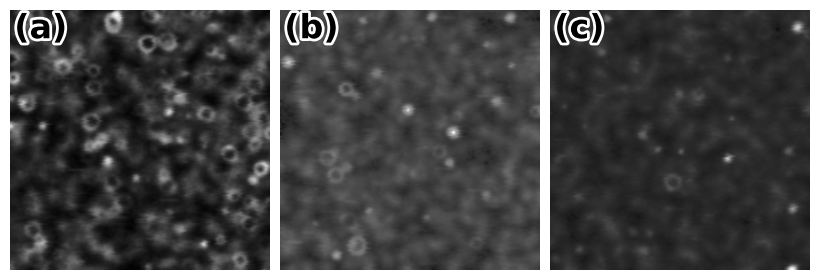

In [8]:
synthetic_data_examples = np.load('synthetic_data/numpy_arrays/train_images.npy')
print(synthetic_data_examples.shape)
# Visualize the Images

# Input your array of 6 images here instead of normalized_imgs
imgs = synthetic_data_examples[:3]
print(imgs.shape)
ref = np.array(['(a)', '(b)', '(c)'])

plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(8, 8))

for col in range(3):
    # First row
    im = ax[col].imshow(imgs[col], cmap='gray') # adjust cmap to gray scale if you like
    
    ax[col].axis('off')
    
    # add reference labels to the subfigures
    text = ax[col].text(10, 5, ref[col], fontsize=24,
            fontweight='heavy', color='black', va='top', ha='left')
    
    text.set_path_effects([path_effects.Stroke(linewidth=4, foreground='white'), 
                       path_effects.Normal()])


plt.tight_layout(pad=0, w_pad=0.3, h_pad=-5)

plt.savefig('C:\\Users\\nkolev\\OneDrive - University College London\\Documents\\GitHub\\SLSQ\\SLSQ_traps\\preds\\synthetic_data_examples.pdf', bbox_inches='tight')

plt.show()

In [64]:
# Define directory path where images are stored
image_dir = 'SLSQ_traps/jpeg versions/' 

# Dictionary to store the images
trap_paths = []
images = []

# Check if the directory exists
if os.path.exists(image_dir):
    # add paths to .pngs in this dir only (not its roots)
    for file in os.listdir(image_dir):
        if file.endswith(".jpeg"):
            trap_paths.append(os.path.join(image_dir, file))
            images.append(file)


predictions = {}
for image_name, path in zip(images,trap_paths):
    predictions[image_name] = predict_image(model,output_path=f'C:\\Users\\nkolev\\OneDrive - University College London\\Documents\\GitHub\\NavigatingTheMatrix\\SLSQ_traps\\jpeg versions\\preds\\prediction_jpeg_{image_name}', 
                                     image_path=path, conf_threshold=0.25, save_output=True, iterations=5)


# print all means and stds
for image_name, pred in predictions.items():
    print(f"Image: {image_name} - Mean donuts: {pred['mean_num_donuts']:.2f}, Std: {pred['std_dev']:.2f}")


0: 640x640 281 donuts, 739.8ms
Speed: 33.7ms preprocess, 739.8ms inference, 28.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 293 donuts, 641.1ms
Speed: 3.7ms preprocess, 641.1ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 278 donuts, 676.5ms
Speed: 4.3ms preprocess, 676.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 285 donuts, 662.6ms
Speed: 4.7ms preprocess, 662.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 276 donuts, 644.3ms
Speed: 4.4ms preprocess, 644.3ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 300 donuts, 697.8ms
Speed: 4.0ms preprocess, 697.8ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)
Mean number of donuts: 286.40 +/- 9.05
Number of donuts detected: 281
Detection image saved to C:\Users\nkolev\OneDrive - University College London\Documents\GitHub\NavigatingTheMatrix\SLSQ_traps\jpeg versions\preds\pr

In [27]:
predictions_dict = count_donuts_in_directory(model, r'C:\Users\nkolev\OneDrive - University College London\Documents\GitHub\NavigatingTheMatrix\SLSQ_traps', conf_threshold=0.2)

Processing 6 images...


  0%|          | 0/6 [00:00<?, ?it/s]


image 1/1 C:\Users\nkolev\OneDrive - University College London\Documents\GitHub\NavigatingTheMatrix\SLSQ_traps\1.jpeg: 640x608 168 donuts, 1388.5ms
Speed: 7.1ms preprocess, 1388.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 608)


 17%|█▋        | 1/6 [00:01<00:07,  1.41s/it]

Number of donuts detected: 168

image 1/1 C:\Users\nkolev\OneDrive - University College London\Documents\GitHub\NavigatingTheMatrix\SLSQ_traps\2.jpeg: 640x640 22 donuts, 1525.0ms
Speed: 6.9ms preprocess, 1525.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 2/6 [00:02<00:05,  1.49s/it]

Number of donuts detected: 22

image 1/1 C:\Users\nkolev\OneDrive - University College London\Documents\GitHub\NavigatingTheMatrix\SLSQ_traps\3.jpeg: 640x640 3 donuts, 1765.3ms
Speed: 6.4ms preprocess, 1765.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 3/6 [00:04<00:04,  1.63s/it]

Number of donuts detected: 3

image 1/1 C:\Users\nkolev\OneDrive - University College London\Documents\GitHub\NavigatingTheMatrix\SLSQ_traps\4.jpeg: 640x640 6 donuts, 1446.7ms
Speed: 6.8ms preprocess, 1446.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 4/6 [00:06<00:03,  1.57s/it]

Number of donuts detected: 6

image 1/1 C:\Users\nkolev\OneDrive - University College London\Documents\GitHub\NavigatingTheMatrix\SLSQ_traps\5.jpeg: 640x640 1 donut, 1180.6ms
Speed: 6.3ms preprocess, 1180.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 5/6 [00:07<00:01,  1.43s/it]

Number of donuts detected: 1

image 1/1 C:\Users\nkolev\OneDrive - University College London\Documents\GitHub\NavigatingTheMatrix\SLSQ_traps\6.jpeg: 640x640 (no detections), 1194.5ms
Speed: 7.0ms preprocess, 1194.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


100%|██████████| 6/6 [00:08<00:00,  1.44s/it]

Number of donuts detected: 0
Total donuts detected: 200 in 6 images
Average donuts per image: 33.33


In [287]:
# let's run a monte-carlo simulation for donut counting

def MC_donut_stats(n: int, reps: int = 1000, plot: bool = True):
    '''
    Runs a mont-e-carlo simulation for the donuts. 
    We assume a the donut locations are random.

    n: number of donuts in the image
    reps: number of repetitions for the simulation
    '''

    stats = {'avg distance': [],
             'min distance': [],
             'max distance': []}

    for i in range(reps):
        # generate random donut locations (within a square of length 1)
        donut_locations = np.random.rand(n, 2) *665.6
        # now find the distance between each pair of donuts
        distances = np.linalg.norm(donut_locations[:, np.newaxis] - donut_locations, axis=2)
        # keep top right corner of the matrix
        distances = distances[np.triu_indices(n, k=1)]
        # find the average distance
        stats['avg distance'].append(np.mean(distances))
        # min distance
        stats['min distance'].append(np.min(distances))
        # max distance
        stats['max distance'].append(np.max(distances))

    # convert to numpy arrays
    for key in stats.keys():
        stats[key] = np.array(stats[key])
    
    bins = 30
    if plot:
        # plot each in a histogram
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        
        # average distance

        axs[0].hist(stats['avg distance'], bins=bins,density=True)
        axs[0].set_title('Average distance')
        axs[0].set_xlabel('Distance (nm)')
        axs[0].set_ylabel('Probability density')
        
        # add a poisson distribution of mean = np.mean(avg distance)
        # get x values
        min_x = np.min(stats['avg distance']).astype(int)
        max_x = np.max(stats['avg distance']).astype(int)
        x = np.linspace(min_x, max_x-1, max_x.astype(int))
        mean_avg = np.mean(stats['avg distance'])
        # get y values
        y2 = [gaussian(i, mean_avg, np.std(stats['avg distance'])) for i in x.astype(int)]
        axs[0].plot(x, y2, color='blue', label='Gaussian distribution')     


        # plot min distance

        axs[1].hist(stats['min distance'], bins=bins,density=True)
        axs[1].set_title('Minimum distance')
        axs[1].set_xlabel('Distance (nm)')
        axs[1].set_ylabel('Probability density')
        
        # add a poisson distribution of mean = np.mean(minimum distance)
        # get x values
        min_x = np.min(stats['min distance']).astype(int)
        max_x = np.max(stats['min distance']).astype(int)
        x = np.linspace(min_x, max_x-1, max_x.astype(int))
        mean_min = np.mean(stats['min distance'])
        # get y values
        y = [poisson(mean_min, i) for i in x.astype(int)]
        y2 = [gaussian(i, mean_min, np.std(stats['min distance'])) for i in x.astype(int)]
        axs[1].plot(x, y2, color='blue', label='Gaussian distribution')
        axs[1].plot(x, y, color='red', label='Poisson distribution')
        
        
        # maximum distance
        
        axs[2].hist(stats['max distance'] , bins=bins, density=True)
        axs[2].set_title('Maximum distance')
        axs[2].set_xlabel('Distance (nm)')
        axs[2].set_ylabel('Probability density')
        # add a poisson distribution of mean = np.mean(maximum distance) and gauss dist
        # get x values
        min_x = np.min(stats['max distance']).astype(int)
        max_x = np.max(stats['max distance']).astype(int)
        x = np.linspace(min_x, max_x-1, max_x.astype(int))
        mean_max = np.mean(stats['max distance'])
        # get y values
        y2 = [gaussian(i, mean_max, np.std(stats['max distance'])) for i in x.astype(int)]
        axs[2].plot(x, y2, color='blue', label='Gaussian distribution')
        
        plt.tight_layout()
        plt.show()
        
    return stats

def poisson(l, x):
    return np.exp(-l) * l**x / np.math.factorial(x)

def gaussian(x, mu, std):
    return (1/(std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / std)**2)

C:\Users\nkolev\AppData\Local\Temp\ipykernel_41896\2260034081.py:99: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.exp(-l) * l**x / np.math.factorial(x)


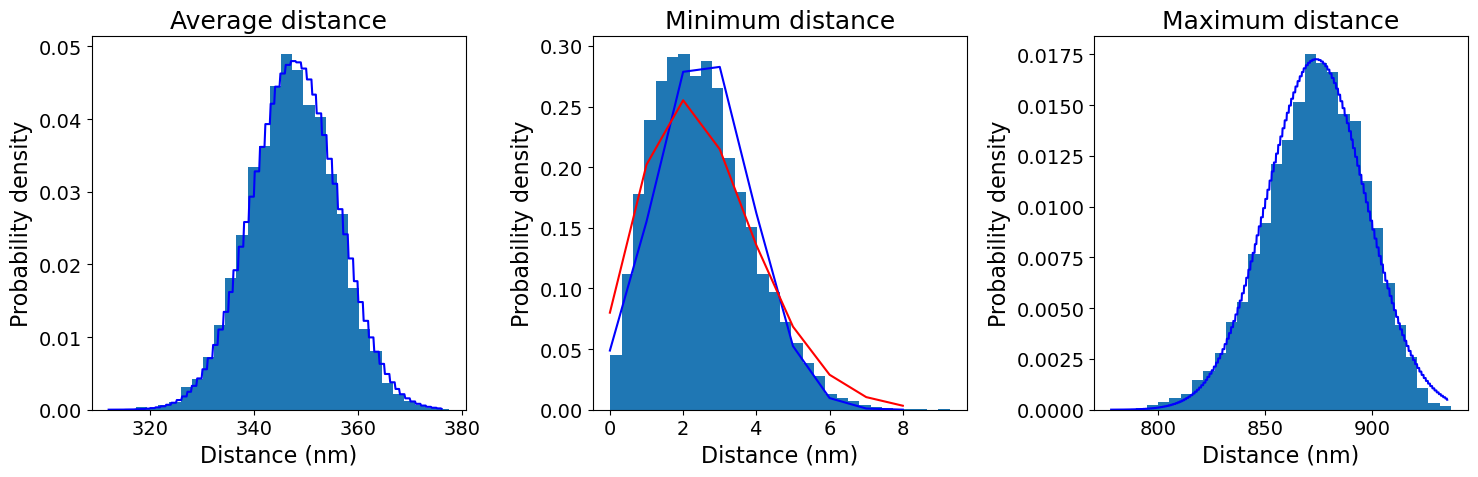

In [288]:
stats = MC_donut_stats(186, reps=10_000, plot=True)

In [297]:
def find_donut_stats(donut_coords: np.ndarray):
    '''
    Finds the donut stats for a given set of donuts

    args:
        donut_coords: Nx2 array of donut coordinates
        donut_radius: radius of the donuts
    
    '''
    x1, y1, x2, y2 = donut_coords.T
    centres = np.array([(x1 + x2) / 2, (y1 + y2) / 2]).T
    # divide by size of image in pixels
    centres /= 640
    # multiply by size of image in nm
    centres *= 665.6
    # now find the distance between each pair of donuts
    distances = np.linalg.norm(centres[:, np.newaxis] - centres, axis=2)
    # keep top right corner of the matrix
    distances = distances[np.triu_indices(len(centres), k=1)]
    # find the average distance
    avg_distance = np.mean(distances)
    # min distance
    min_distance = np.min(distances)
    # max distance
    max_distance = np.max(distances)
    print(f'Average distance: {avg_distance}')
    print(f'Min distance: {min_distance}')
    print(f'Max distance: {max_distance}')

    return avg_distance, min_distance, max_distance

def compare_and_plot_donut_stats(predictions: dict):
    '''
    Compares the donut stats from the predictions with the monte-carlo simulation
    and plots the results.

    args:
        predictions: dictionary of predictions
    '''
    
    # get stats for the predictions
    real_stats = find_donut_stats(predictions['boxes'])
    # get stats for the monte-carlo simulation
    N = predictions['boxes'].shape[0]
    mc_stats = MC_donut_stats(N, reps=10_000, plot=False)

    bins = 50
    # plot each in a histogram
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    axs[0].hist(mc_stats['avg distance'], bins=bins,density=True)
    axs[0].set_title('Average distance')
    axs[0].set_xlabel('Distance (nm)')
    axs[0].set_ylabel('Probability density')
    # add a line for the average distance from the data
    axs[0].axvline(real_stats[0], color='red', linestyle='dashed', linewidth=1)
    axs[0].legend(['Sample average distance'], loc='upper right', fontsize=10, bbox_to_anchor=(1, 1))
    axs[1].hist(mc_stats['min distance'], bins=bins,density=True)
    axs[1].set_title('Minimum distance')
    axs[1].set_xlabel('Distance (nm)')
    axs[1].set_ylabel('Probability density')
    # add a line for the min distance from the data
    axs[1].axvline(real_stats[1], color='red', linestyle='dashed', linewidth=1)
    axs[1].legend(['Sample minimum distance'], loc='upper right', fontsize=10, bbox_to_anchor=(1, 1))
    axs[2].hist(mc_stats['max distance'], bins=bins,density=True)
    axs[2].set_title('Maximum distance')
    axs[2].set_xlabel('Distance (nm)')
    axs[2].set_ylabel('Probability density')
    # add a line for the max distance from the data
    axs[2].axvline(real_stats[2], color='red', linestyle='dashed', linewidth=1)
    axs[2].legend(['Sample maximum distance'], loc='upper right', fontsize=10, bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

    # calculate p-values and z scores (sigmas) for each of the stats
    p_values = {}
    z_scores = {}
    # avg_distance
    p_values['avg distance'], z_scores['avg distance'] = get_p_value(mc_stats['avg distance'], real_stats[0])
   # print(f'P-value for average distance: {p_values["avg distance"]}')
    print(f'Sigma for average distance: {z_scores["avg distance"]}')
    # min_distance
    p_values['min distance'], z_scores['min distance'] = get_p_value(mc_stats['min distance'], real_stats[1])
   # print(f'P-value for minimum distance: {p_values["min distance"]}')
    print(f'Sigma for minimum distance: {z_scores["min distance"]}')
    # max_distance
    p_values['max distance'], z_scores['max distance'] = get_p_value(mc_stats['max distance'], real_stats[2])
   # print(f'P-value for maximum distance: {p_values["max distance"]}')
    print(f'Sigma for maximum distance: {z_scores["max distance"]}')  

    
    return real_stats, mc_stats, p_values

def get_p_value(distribution, value):
    '''
    Function to calculate the p-value for a given value from a distribution.
    distribution: numpy array of the distribution
    value: value to calculate the p-value for
    '''
    # calculate the z-score
    mean = np.mean(distribution)
    std = np.std(distribution)
    z = (value - mean) / std
    # calculate the p-value
    p_value = norm.sf(abs(z))
    return p_value, z

dummy_SLSQA_003.png
Average distance: 351.26385498046875
Min distance: 3.4895875453948975
Max distance: 890.0317993164062


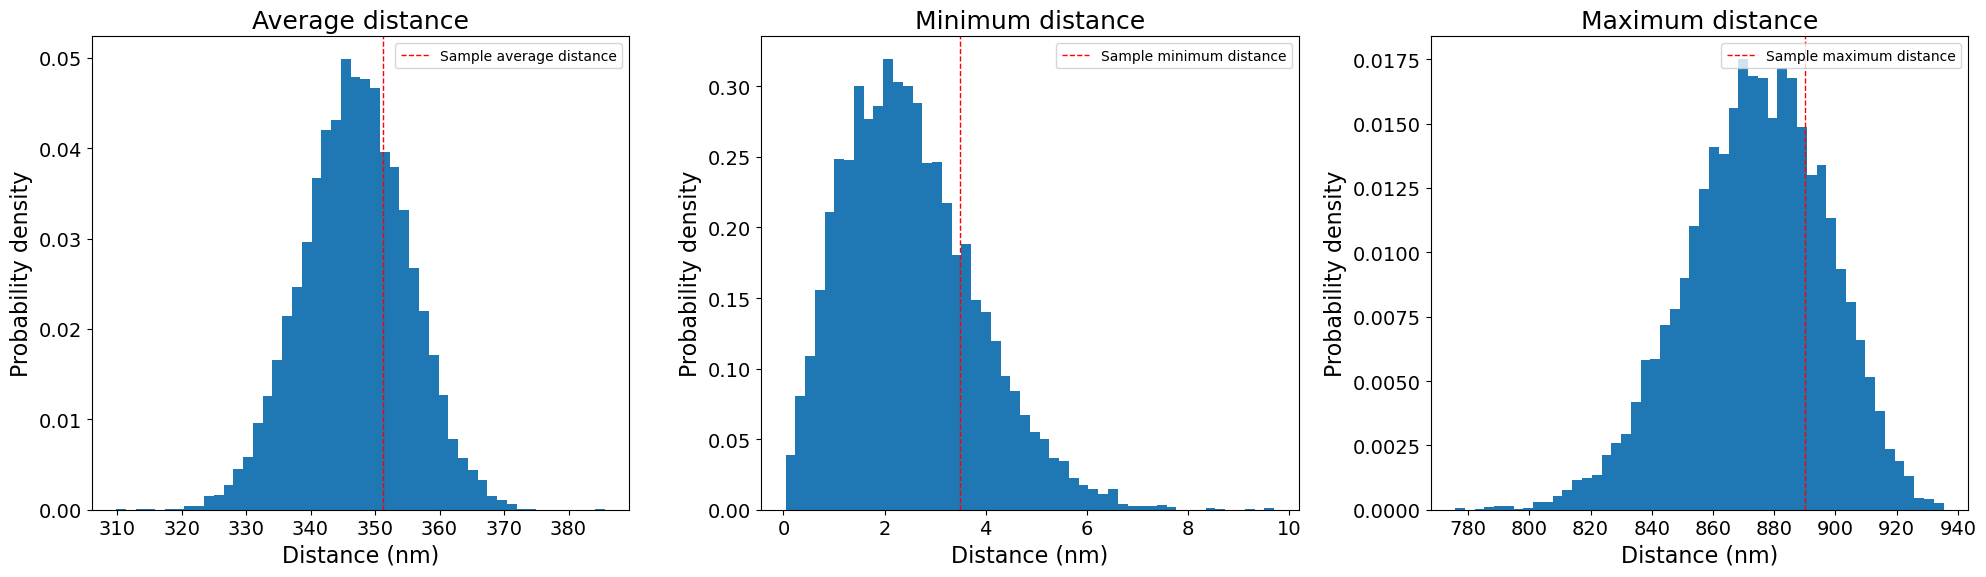

Sigma for average distance: 0.5214923777990008
Sigma for minimum distance: 0.7339230360177433
Sigma for maximum distance: 0.6965323478267792
dummy_SLSQC_006.png
Average distance: 339.92254638671875
Min distance: 3.9810807704925537
Max distance: 822.0433349609375


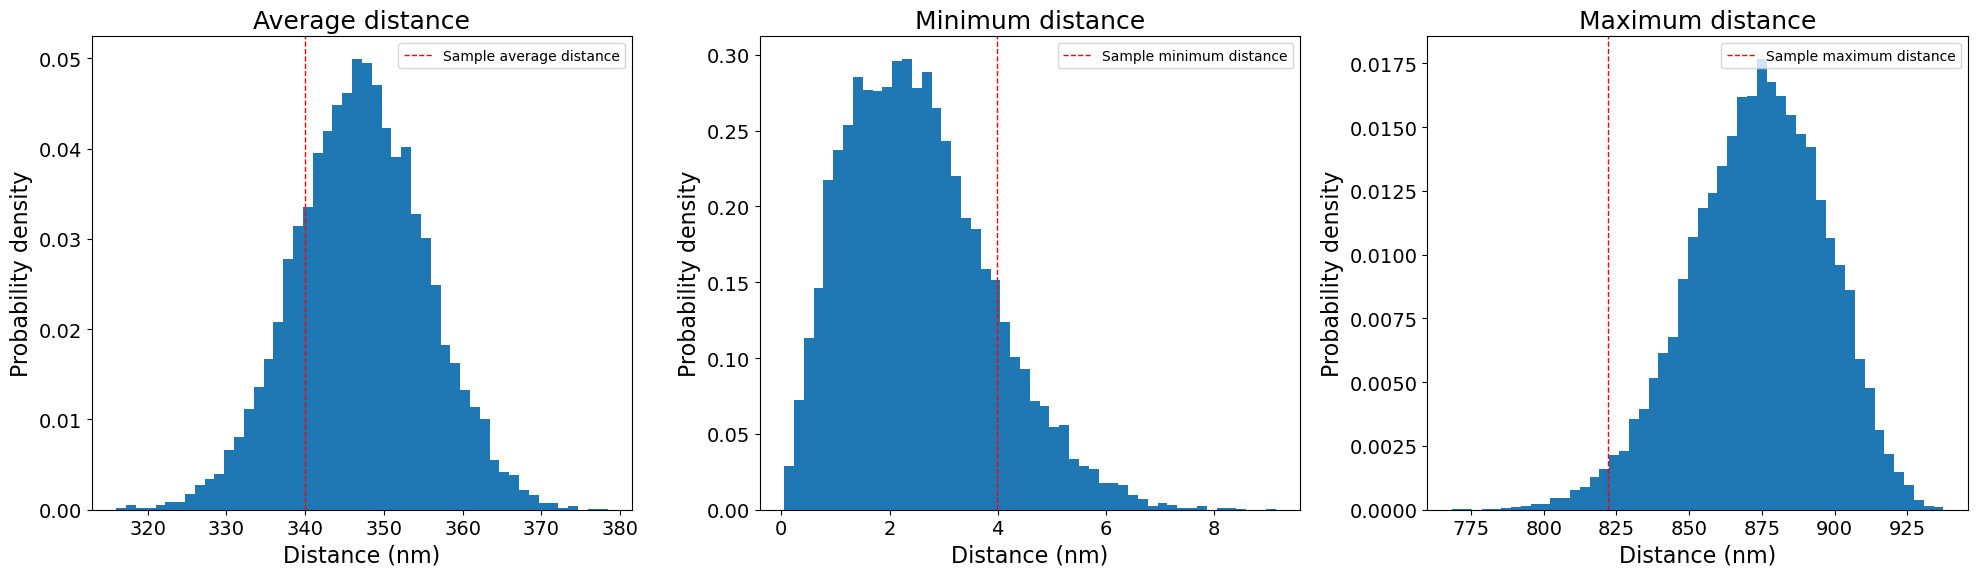

Sigma for average distance: -0.8561180625540815
Sigma for minimum distance: 1.0818615191952916
Sigma for maximum distance: -2.204252187676866
dummy_SLSQH_012.png
Average distance: 348.6600646972656
Min distance: 49.35790252685547
Max distance: 721.8790283203125


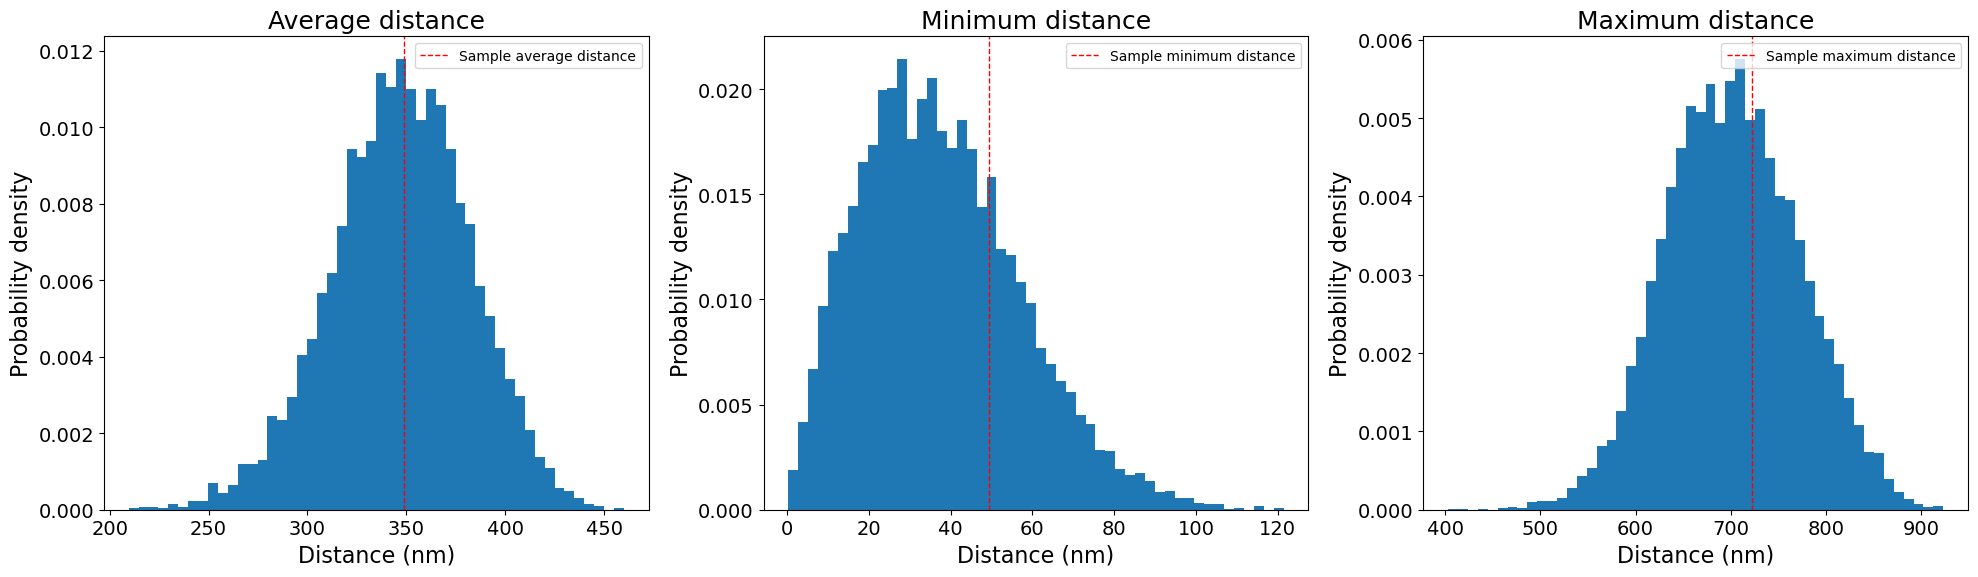

Sigma for average distance: 0.04153101070448132
Sigma for minimum distance: 0.5993153662936848
Sigma for maximum distance: 0.28119051180101623
real_SLSQA_012.png
Average distance: 364.9211730957031
Min distance: 9.963746070861816
Max distance: 737.4602661132812


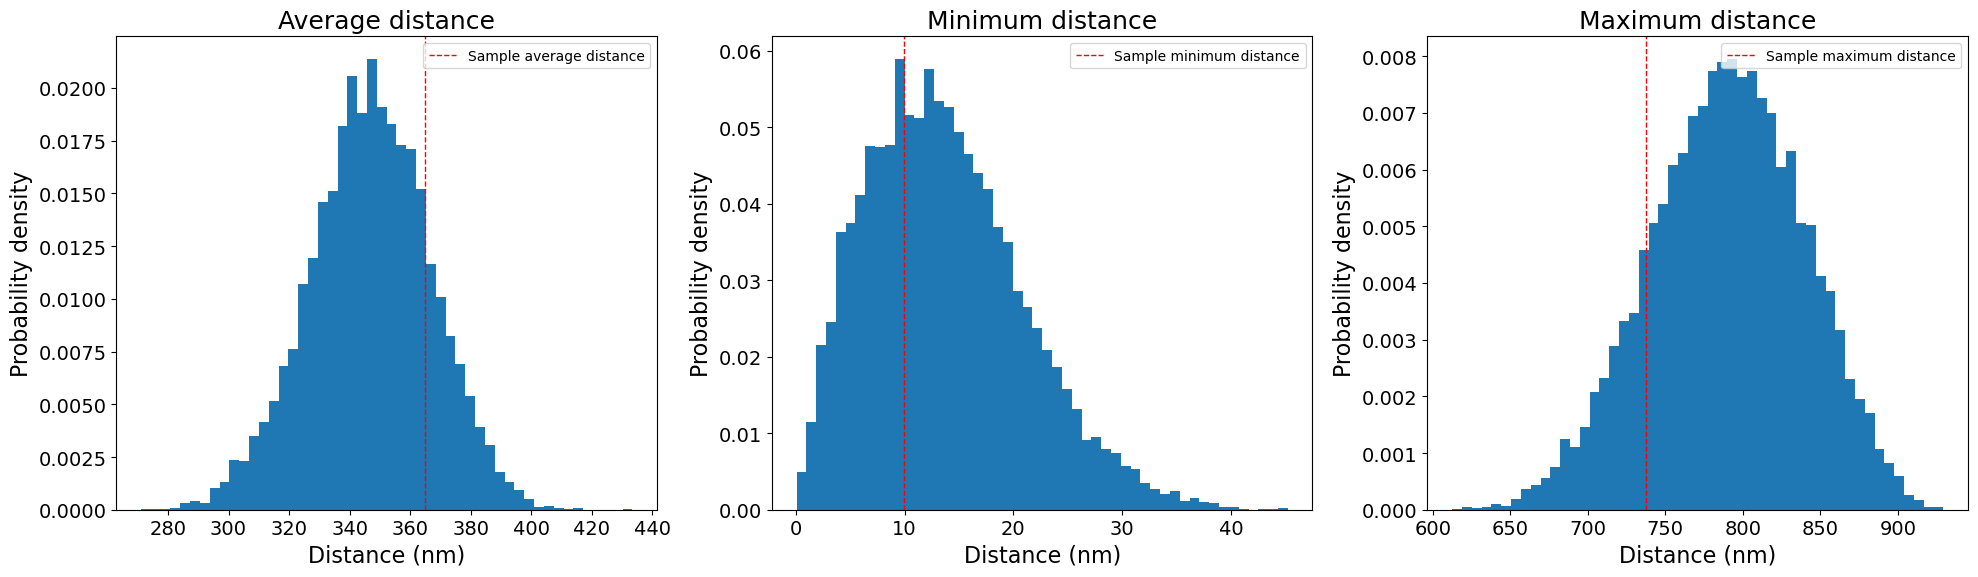

Sigma for average distance: 0.9077114384838962
Sigma for minimum distance: -0.5219158340805722
Sigma for maximum distance: -1.055628607439577
real_SLSQC_141.png
Average distance: 362.12274169921875
Min distance: 6.741605758666992
Max distance: 747.39404296875


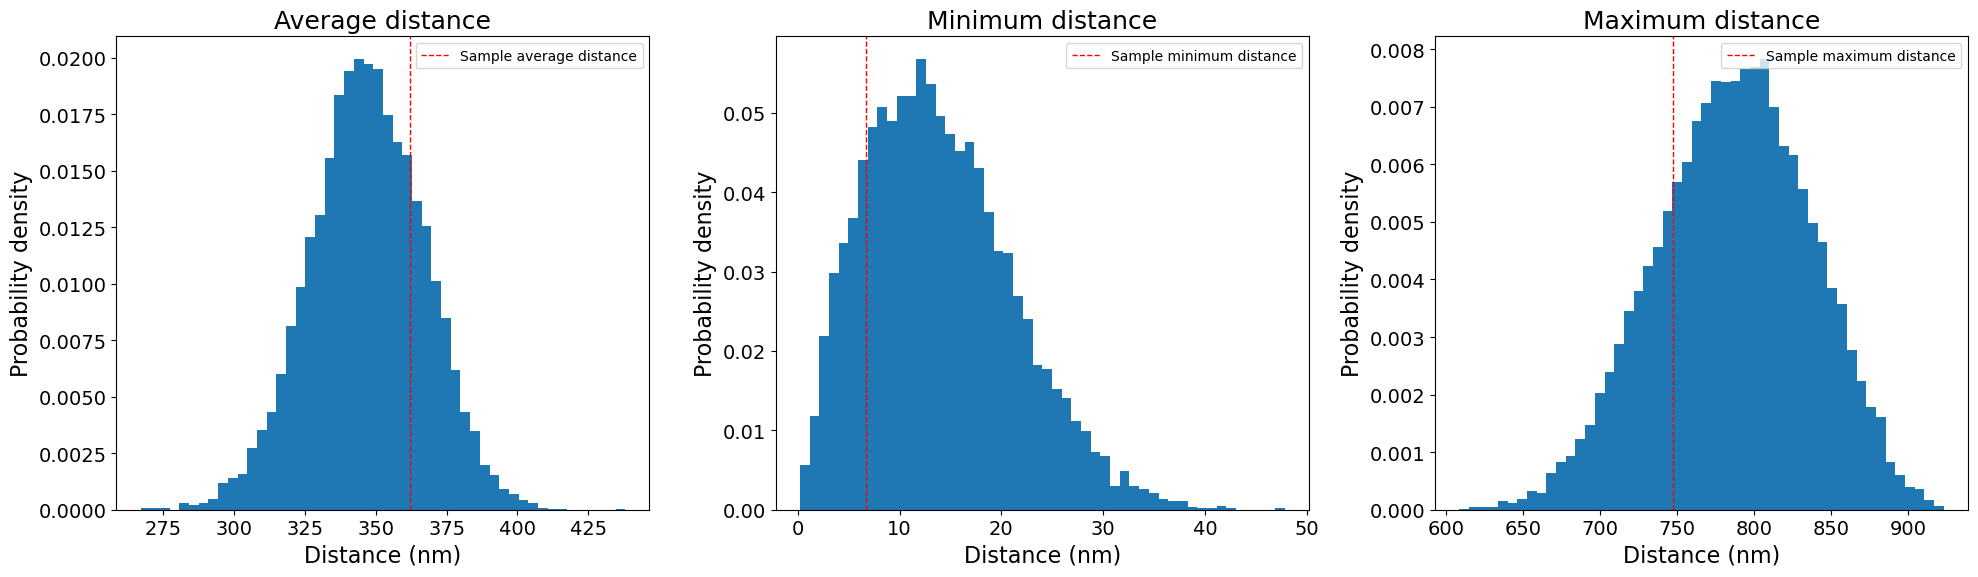

Sigma for average distance: 0.7530853444859018
Sigma for minimum distance: -0.9987893166380006
Sigma for maximum distance: -0.7784759389325228
real_SLSQH_008.png
Average distance: 445.7403869628906
Min distance: 96.68509674072266
Max distance: 707.7272338867188


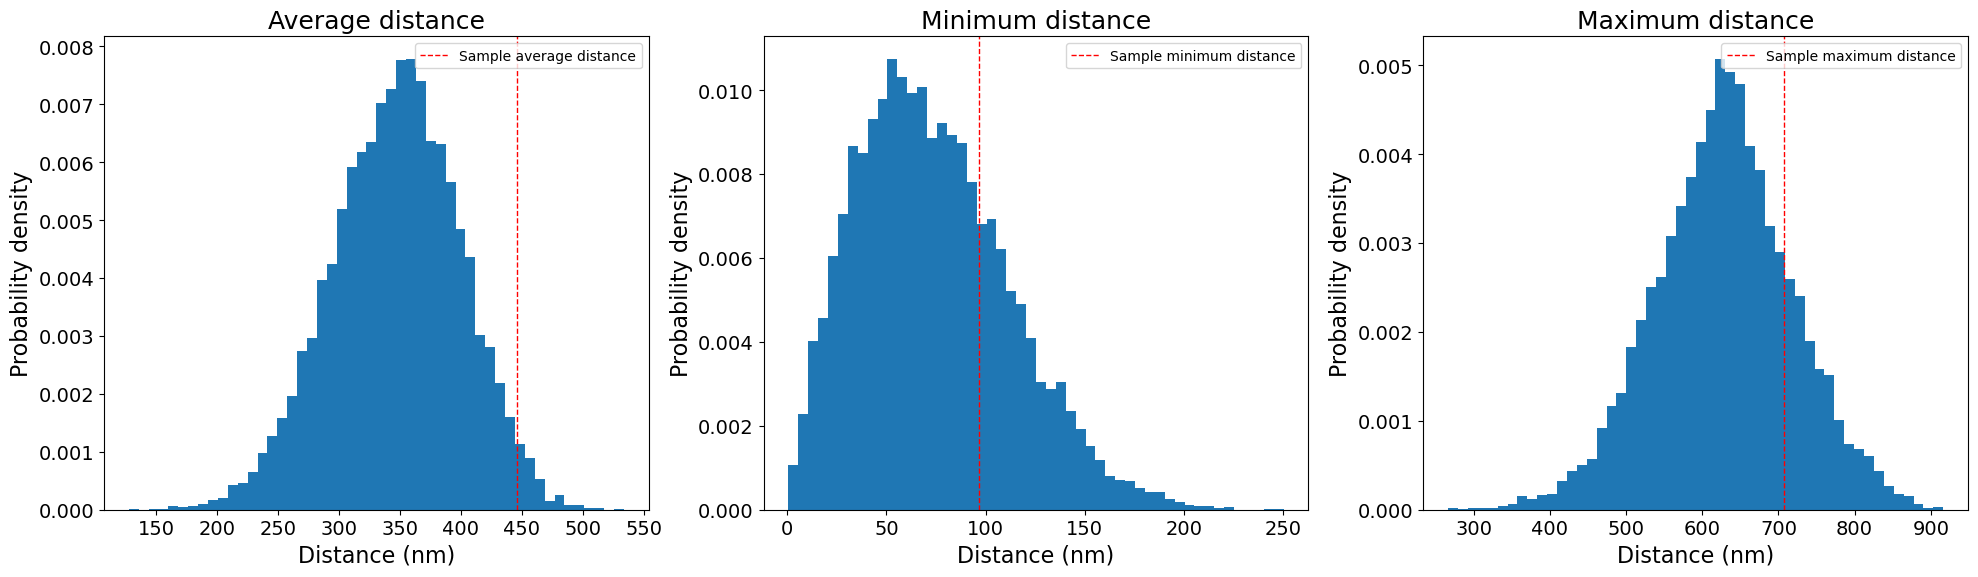

Sigma for average distance: 1.8858133691985497
Sigma for minimum distance: 0.5955077006999705
Sigma for maximum distance: 0.8807310392859707


In [298]:
stats_dict = {}
for key, value in predictions.items():
    print(key)
    stats_dict[key] = compare_and_plot_donut_stats(value)
     